In [1]:
import pandas as pd
import os 
import matplotlib.pyplot as plt
from functools import partial
import pdb
from scipy import stats
import numpy as np
%matplotlib inline
import statsmodels.api as sm

In [2]:
file = '../data/dataset_2.3.4.4.csv'
df34 = pd.read_csv(file).infer_objects()
df34.rename(columns={'Unnamed: 0':'Date'},inplace=True)

df2=df34.loc[:,'0.1':'0.95']*1

for hpd in range(10,100,5):
    df2['HPD%s'%(hpd)] = df2[str(hpd/100)]*(hpd/100)
    df2.drop([str(hpd/100)],axis=1,inplace=True)
df2['HPD'] = df2.loc[:,'HPD10':'HPD95'].apply(lambda x:
                                    min(list(filter(lambda s:s!=0,x.to_list())))
                                    if list(filter(lambda s:s!=0,x.to_list()))!=[]
                                    else 0,axis=1)
df34.drop(['0.1','0.15','0.2','0.25','0.3','0.35','0.4','0.45','0.5','0.55','0.6','0.65','0.7',
          '0.75','0.8','0.85','0.9','0.95'],axis=1,inplace=True)

df34['virus'] = df2['HPD']

In [3]:
df = df34.copy().replace(0, np.NaN)
virus_mean_monthly = df.groupby(['point','month'],as_index=False)['virus'].mean()
virus_min_monthly = df.groupby(['point','month'],as_index=False)['virus'].min()
virus_max_monthly = df.groupby(['point','month'],as_index=False)['virus'].max()
vmean = virus_mean_monthly.pivot(index='point',values='virus',columns='month')
vmin = virus_min_monthly.pivot(index='point',values='virus',columns='month')
vmax = virus_max_monthly.pivot(index='point',values='virus',columns='month')

In [4]:
bird_all_monthly = df34.groupby(['point','month'],as_index=False)['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes',
                           'Procellariiformes'].mean()
#bird_all_monthly.to_csv(r'../data/2.3.4.4_crosscorr/allbirds_prob.csv')

pele = bird_all_monthly.pivot(index='point',columns='month',values='Pelecaniformes')
gru = bird_all_monthly.pivot(index='point',columns='month',values='Gruiformes')
pas = bird_all_monthly.pivot(index='point',columns='month',values='Passeriformes')
suli = bird_all_monthly.pivot(index='point',columns='month',values='Suliformes')
cico = bird_all_monthly.pivot(index='point',columns='month',values='Ciconiiformes')
falc = bird_all_monthly.pivot(index='point',columns='month',values='Falconiformes')
chara = bird_all_monthly.pivot(index='point',columns='month',values='Charadriiformes')
ans = bird_all_monthly.pivot(index='point',columns='month',values='Anseriformes')
acci = bird_all_monthly.pivot(index='point',columns='month',values='Accipitriformes')

<ipython-input-4-be87a1f013cb>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  bird_all_monthly = df34.groupby(['point','month'],as_index=False)['Pelecaniformes','Gruiformes','Passeriformes',


In [5]:
bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1104: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))


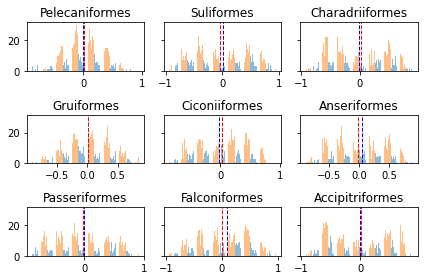

In [27]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
crosscrr_mean = pd.DataFrame()
crosscrr_min = pd.DataFrame()
crosscrr_max = pd.DataFrame()

virus_prob_rand = vmean.copy()
virus_prob = vmean.copy()
for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)


bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False)
    
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,1],m_rand.iloc[:,1]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,1].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,1].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
#fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_0moLag.png',figsize=[12,12],dpi=300)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1104: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
<ipython-input-9-912808cec4c6>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_1moLag.png',figsize=[12,12],dpi=300)


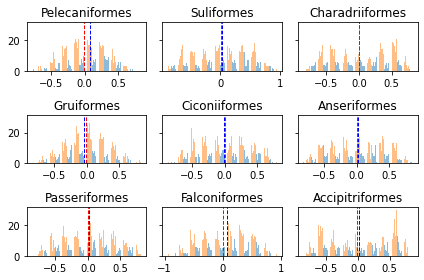

In [9]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
crosscrr_mean = pd.DataFrame()
crosscrr_min = pd.DataFrame()
crosscrr_max = pd.DataFrame()

virus_prob_rand = vmean.copy()
virus_prob = vmean.copy()
for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)


bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False)
    
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,2],m_rand.iloc[:,2]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,2].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,2].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
    #mmean = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
    #mmin = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].min()
    #mmax = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].max()
    #crosscrr_mean = pd.concat([crosscrr_mean,mmean.rename(i)],axis=1)
    #crosscrr_min = pd.concat([crosscrr_min,mmin.rename(i)],axis=1)
    #crosscrr_max = pd.concat([crosscrr_max,mmax.rename(i)],axis=1)
    #crosscrr_mean.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_mean.csv')
    #crosscrr_min.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_min.csv')
    #crosscrr_max.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_max.csv')
    
fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_1moLag.png',figsize=[12,12],dpi=300)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/stattools.py:1104: RuntimeWarning: invalid value encountered in true_divide
  return cvf / (np.std(x) * np.std(y))
<ipython-input-6-c2ac0d9c6999>:55: MatplotlibDeprecationWarning: savefig() got unexpected keyword argument "figsize" which is no longer supported as of 3.3 and will become an error in 3.6
  fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_2moLag.png',figsize=[12,12],dpi=300)


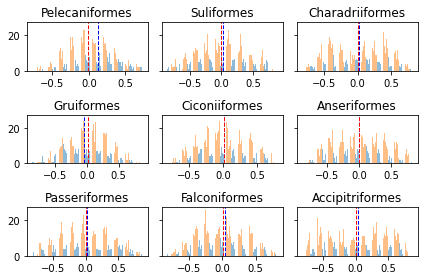

In [6]:
'''Cross-correlation of virus probablity and bird probability of each bird Order'''
crosscrr_mean = pd.DataFrame()
crosscrr_min = pd.DataFrame()
crosscrr_max = pd.DataFrame()

virus_prob_rand = vmean.copy()
virus_prob = vmean.copy()
for row in range(0,1000):
    virus_prob_rand.iloc[row,:] = np.random.random(12)


bird_orders = pd.Series([pele,gru,pas,suli,cico,falc,chara,ans,acci],index=['Pelecaniformes','Gruiformes','Passeriformes',
                           'Suliformes', 'Ciconiiformes', 'Falconiformes',
                           'Charadriiformes', 'Anseriformes', 'Accipitriformes'])

fig, axs = plt.subplots(3,3,sharey=True, tight_layout=True)

r=0
c=0
for i in bird_orders.index:
    x = bird_orders.loc[i]
    crr_m = virus_prob
    crr_m_rand = virus_prob_rand
    for point in range(len(x)):
        crr_m.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob.iloc[point,:], x.iloc[point,:], adjusted=False)
        crr_m_rand.iloc[point,:] = sm.tsa.stattools.ccf(virus_prob_rand.iloc[point,:], x.iloc[point,:], adjusted=False)
    
    crr_m.to_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    crr_m_rand.to_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    
    axs[r,c].hist([m.iloc[:,3],m_rand.iloc[:,3]],bins=100,alpha=0.5)
    axs[r,c].axvline(m.iloc[:,3].mean(), color='blue', linestyle='dashed', linewidth=1)
    axs[r,c].axvline(m_rand.iloc[:,3].mean(), color='red', linestyle='dashed', linewidth=1)

    axs[r,c].set_title(r'%s'%i)
    
    if r<2:
        r += 1
    elif r==2 and c<2:
        r = 0
        c += 1
    
    #mmean = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].mean()
    #mmin = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].min()
    #mmax = m.iloc[:,[1,2,3,4,5,6,7,8,9,10,11,12]].max()
    #crosscrr_mean = pd.concat([crosscrr_mean,mmean.rename(i)],axis=1)
    #crosscrr_min = pd.concat([crosscrr_min,mmin.rename(i)],axis=1)
    #crosscrr_max = pd.concat([crosscrr_max,mmax.rename(i)],axis=1)
    #crosscrr_mean.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_mean.csv')
    #crosscrr_min.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_min.csv')
    #crosscrr_max.to_csv(r'../data/2.3.4.4_crosscorr/crosscrr_max.csv')
    
fig.savefig(r'../data/2.3.4.4_crosscorr/Crr_2moLag.png',figsize=[12,12],dpi=300)

In [8]:
import scipy.stats as stats
for i in bird_orders.index:
    m = pd.read_csv(r'../data/2.3.4.4_crosscorr/Monthly_crr_%s.csv'%i)
    m_rand = pd.read_csv(r'../data/2.3.4.4_crosscorr/Rand_crr_%s.csv'%i)
    #perform two sample t-test with equal variances
    for lag in range(1,7):
        ttest = stats.ttest_ind(a=m.dropna().iloc[:,lag], b=m_rand.dropna().iloc[:,lag], equal_var=True)
        if (ttest.pvalue < 0.05) & (ttest.statistic>0):
            print('lag=',lag-1,i,'Correlation coeficient=',ttest.statistic,'p value=',ttest.pvalue)

lag= 1 Pelecaniformes Correlation coeficient= 4.900166571375901 p value= 1.070675697386185e-06
lag= 2 Pelecaniformes Correlation coeficient= 7.7030970175294495 p value= 2.5201290631458937e-14
lag= 3 Pelecaniformes Correlation coeficient= 5.4364843551852156 p value= 6.417772684227017e-08
lag= 4 Pelecaniformes Correlation coeficient= 3.2677674926835523 p value= 0.0011106429678883895
lag= 5 Pelecaniformes Correlation coeficient= 2.4546484828485258 p value= 0.014224886184956065
lag= 0 Suliformes Correlation coeficient= 2.1075001787648633 p value= 0.03525437131599307
lag= 1 Suliformes Correlation coeficient= 2.5793973489466753 p value= 0.010000054863166373
lag= 2 Suliformes Correlation coeficient= 2.364402627845786 p value= 0.018197070783674003
lag= 3 Ciconiiformes Correlation coeficient= 2.0022922165009573 p value= 0.04544882724142282
lag= 4 Ciconiiformes Correlation coeficient= 2.78987567403208 p value= 0.005345410998718474
lag= 5 Ciconiiformes Correlation coeficient= 3.06301842794871 p v